In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
%matplotlib inline

#read data
df = pd.read_csv('listings.csv')
df.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


## A look of the data

In [2]:
df = df.dropna(how = 'all', axis = 1).dropna(how = 'all', axis = 1)

In [3]:
df.shape

(3818, 91)

In [4]:
#the columns with no null
no_nulls = list(df.columns[df.isnull().mean()==0])
len(no_nulls) / df.shape[1]

0.5164835164835165

In [5]:
#the columns with 75% empty value
missing_nulls = list(df.columns[df.isnull().mean()>0.75])
missing_nulls

['square_feet']

### zip code distritubution vs price

In [6]:
count_vals = df.zipcode.value_counts()
count_vals

98122        420
98103        394
98102        339
98105        225
98109        202
98101        201
98144        200
98121        196
98107        180
98115        178
98112        167
98117        164
98118        154
98119        143
98116        112
98104         95
98125         71
98199         66
98126         63
98106         58
98108         56
98133         46
98136         44
98177         19
98178          7
98146          5
98134          5
99\n98122      1
Name: zipcode, dtype: int64

In [7]:
df = df.drop(df.loc[df['zipcode']=="99\n98122"].index, axis = 0)

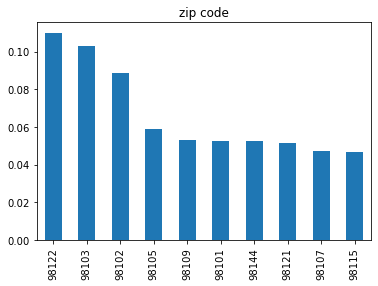

In [8]:
(count_vals[:10]/df.shape[0]).plot(kind="bar");
plt.title("zip code");

In [9]:
df['price'] = df.price.str.replace(',','').str[1:-3].astype('int64')

In [10]:
zip_df = pd.DataFrame(df.groupby(['zipcode']).mean()['price'].sort_values().dropna().sort_values(ascending = False))

In [11]:
zip_df['review_scores_location'] = df.groupby(['zipcode']).mean()['review_scores_location'].sort_values(ascending=False)

In [12]:
zip_df = zip_df.reset_index().sort_values('zipcode')

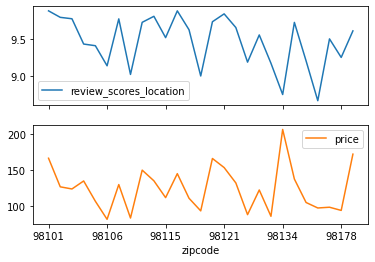

In [13]:
zip_df.plot.line(x='zipcode', y=['review_scores_location','price'],subplots=True);

## Clean the data

In [14]:
interest_col = 
df = df[interest_col]

SyntaxError: invalid syntax (3852850465.py, line 1)

In [ ]:
#find the numeric variable
num_vars = df.select_dtypes(include=['float', 'int']).columns
df[num_vars].describe().loc['count']
num_vars

In [ ]:
df[['number_of_reviews', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'calculated_host_listings_count']].head()

In [ ]:
#find the categorical variable
cat_vars = df.select_dtypes(include=['object']).columns
cat_vars

In [ ]:
df[['smart_location']].value_counts()

In [ ]:
# def clean_data(df):
#     '''
#     INPUT
#     df - pandas dataframe 
    
#     OUTPUT
#     X - A matrix holding all of the variables you want to consider when predicting the response
#     y - the corresponding response vector
    
#     This function cleans df using the following steps to produce X and y:
#     1. Drop all the rows with no salaries
#     2. Create X as all the columns that are not the Salary column
#     3. Create y as the Salary column
#     4. Drop the Salary, Respondent, and the ExpectedSalary columns from X
#     5. For each numeric variable in X, fill the column with the mean value of the column.
#     6. Create dummy columns for all the categorical variables in X, drop the original columns
#     '''
#     # Drop rows with missing salary values
#     df = df.dropna(subset=['Price'], axis=0)
#     y = df['Salary']
    
#     #Drop respondent and expected salary columns
#     df = df.drop(['Respondent', 'ExpectedSalary', 'Salary'], axis=1)
    
#     # Fill numeric columns with the mean
#     num_vars = df.select_dtypes(include=['float', 'int']).columns
#     for col in num_vars:
#         df[col].fillna((df[col].mean()), inplace=True)
        
#     # Dummy the categorical variables
#     cat_vars = df.select_dtypes(include=['object']).copy().columns
#     for var in  cat_vars:
#         # for each cat add dummy var, drop original column
#         df = pd.concat([df.drop(var, axis=1), pd.get_dummies(df[var], prefix=var, prefix_sep='_', drop_first=True, dummy_na= True)], axis=1)
    
#     X = df
#     return X, y